# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import pickle
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from google.colab import drive
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Input
from keras import optimizers

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# **Helper functions**

In [ ]:
def onehot(y):

  y_onehot = []

  for i in y.to_numpy():
    if i == 1: y_onehot.append([0, 1])
    else: y_onehot.append([1, 0])

  y_onehot = np.array(y_onehot)

  return y_onehot

In [ ]:
def myconfusion_matrix(y_true, y_pred):
  tp, tn, fp, fn = 0, 0, 0, 0

  for i in range(0, len(y_true)):
    if y_pred[i] == y_true[i]:
      if y_pred[i] == 0:
        tn = tn + 1
      else:
        tp = tp + 1
    else:
      if y_pred[i] == 0:
        fn = fn + 1
      else:
        fp = fp + 1

  return tp, tn, fp, fn

#Calculates the metrics: accuracy, recall, precision, f1_score, and specificity
def myaccuracy(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + tn + fp + fn) == 0: return 0
    return (tp + tn) / (tp + tn + fp + fn)

def myrecall(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + fn) == 0: return 0
    return tp / (tp + fn)

def myprecision(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + fp) == 0: return 0
    return tp / (tp + fp)

def myf1_score(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    denom = (myprecision(y_true, y_pred) + myrecall(y_true, y_pred))
    if denom == 0: return 0
    return 2 * (myprecision(y_true, y_pred) * myrecall(y_true, y_pred)) / denom

def myspecificity(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tn + fp) == 0: return 0
    return tn / (tn + fp)

# **Congeintal Syphilis**

## Import data set

In [ ]:
dir = 'IGTD/Datasets/Syphilis/Train/Results.pkl'

data = []

with open(dir, "rb") as file:
  for i in range(0, 3):
    data.append(pickle.load(file))

X_train = np.moveaxis(data[1], 2, 0)
X_train = np.expand_dims(X_train, 3)

dir = 'IGTD/Datasets/Syphilis/Test/Results.pkl'

data = []

with open(dir, "rb") as file:
  for i in range(0, 3):
    data.append(pickle.load(file))

X_test = np.moveaxis(data[1], 2, 0)
X_test = np.expand_dims(X_test, 3)


y_train = pd.read_csv('Tabular data sets/Syphilis/y_train.csv', sep=';')
y_test = pd.read_csv('Tabular data sets/Syphilis/y_test.csv', sep=';')

enc = OneHotEncoder(categories='auto', sparse_output=False)

y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
shapes = pd.DataFrame(
    {
        "Train": [X_train.shape, y_train.shape],
        "Test": [X_test.shape, y_test.shape]
    },
    index=['x', 'y']
)

shapes

,Train,Test
x,"(1321, 8, 8, 1)","(331, 8, 8, 1)"
y,"(1321, 2)","(331, 2)"


In [ ]:
print(Counter(np.argmax(y_train, axis=1)))
print(Counter(np.argmax(y_test, axis=1)))

Counter({1: 661, 0: 660})
Counter({0: 166, 1: 165})


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1321, 8, 8, 1)
(331, 8, 8, 1)
(1321, 2)
(331, 2)


## Basic CNN - Congeintal Syphilis

In [ ]:
# Baseline Model model

basic_model = Sequential([
                    Input(X_train[0].shape),
                    Conv2D(32, 3, 1, padding="same", activation="relu", data_format='channels_last'),
                    MaxPooling2D(pool_size=2, strides=1, padding="same"),
                    Flatten(),
                    Dense(2, activation="sigmoid")
                    ])

basic_model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

In [ ]:
# Fit baseline model

basic_history = basic_model.fit(
                      X_train,
                      y_train,
                      batch_size=256,
                      epochs=200,
                      shuffle=True,
                      validation_split=0.1,
                      verbose=0,
                  )

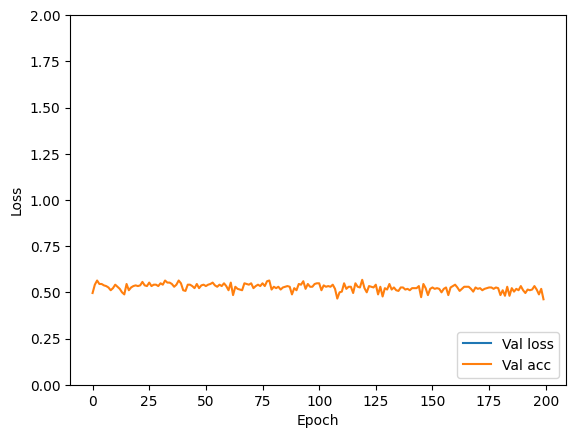

In [ ]:
# Plot graph
#plt.plot(basic_history.history['loss'], label='Train loss')
#plt.plot(basic_history.history['binary_accuracy'], label='Train acc')
plt.plot(basic_history.history['val_loss'], label = 'Val loss')
plt.plot(basic_history.history['val_binary_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

In [ ]:
### GET BEST EPOCHS ###

val_acc_per_epoch = basic_history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('\nBest epoch: %d' % (best_epoch))


Best epoch: 120


In [ ]:
# Redefining specificity beacause 1=negative, 0=positive
def myspecificity(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tn + fp) == 0: return 0
    return tp / (tp + fn)

# Loading the model
dir = 'IGTD_basic_cong_syphilis.pkl'

with open(dir, 'rb') as file:
  basic_model = pickle.load(file)

basic_model.summary()

best_epoch = 30

In [ ]:
#Gerando o relatorio dos experimentos
mydados_relatorio_modelo = []

header_dados_relatorio_modelo = ['acc', 'recall', 'precision', 'f1_score', 'specificity']

y_true = [np.argmax(x) for x in y_test]

for exp in range(0, 30):

    basic_model.fit(X_train, y_train, epochs=best_epoch, verbose=0)

    y_pred = basic_model.predict(X_test)
    y_pred = [np.argmax(x) for x in y_pred]

    # Based on my confusion matrix
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)

    my_accuracy = accuracy_score(y_true, y_pred)
    my_recall = recall_score(y_true, y_pred, average='binary', pos_label=0)
    my_precision = precision_score(y_true, y_pred, average='binary', pos_label=0)
    my_f1_score = f1_score(y_true, y_pred, average='binary', pos_label=0)
    my_specificity = myspecificity(y_true, y_pred)

    # Metrics

    # My confusionmatrix
    mydados_relatorio_modelo.append([my_accuracy, my_recall, my_precision, my_f1_score, my_specificity])

# Saving metrics in a datframe
mydados_relatorio_modelo_df = pd.DataFrame(mydados_relatorio_modelo, columns=header_dados_relatorio_modelo)

11/11 [==============================] - 0s 4ms/step


In [ ]:
final_report = pd.DataFrame(mydados_relatorio_modelo_df.mean(axis=0))

In [ ]:
final_report

,0
acc,0.499194
recall,0.555823
precision,0.500440
f1_score,0.526138
specificity,0.555823


## Saving normal results

In [ ]:
# Save results

report_dir = 'Results/Cong-Syphilis/report/IGTD_basic_cong_syphilis_report.csv'
final_dir = 'Results/Cong-Syphilis/IGTD_basic_cong_syphilis_mean.csv'

mydados_relatorio_modelo_df.to_csv(report_dir, sep=';')
final_report.to_csv(final_dir, sep=';')

# Save model

dir = 'Models/Cong-Syphilis/IGTD_basic_cong_syphilis.pkl'

with open(dir, 'wb') as file:
  pickle.dump(basic_model, file)